In [1]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

# Data Prep

In [2]:
datasets = {
            'mirna': '../data/luad/LUAD_mirna.csv',
            'mrna': '../data/luad/LUAD_mrna.csv',
            'prot': '../data/luad/LUAD_protein.csv',
            'lncrna': '../data/luad/LUAD_lncrna.csv',
}
        
labels = '../data/luad/pathologic_stage.csv'

In [3]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    data[modality] = data[modality].loc[~data[modality].index.duplicated(keep='first')]

In [4]:
for modality in data:
    print(modality + str(data[modality].shape))

mirna(453, 1870)
mrna(516, 20473)
prot(364, 200)
lncrna(489, 12727)


## Preprocessing

To prep data for downstream analysis, we need to:
- Basic filtering (select genes that are in at least 3 samples)
- Library size normalization (10,000 per sample)
- Log Transform mrna, mirna, and lncrna
- Remove null columns and columns with low variance
- Merge data so that we are using the same samples for all omics datasets

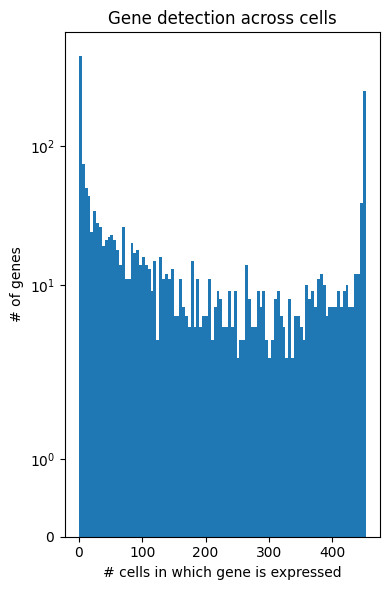

In [209]:
genes_per_cell = np.sum(data['mirna'] > 0, axis=0)

fig, ax = plt.subplots(1, figsize=(4,6))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across samples')
fig.tight_layout()

In [5]:
def filter(df, num):
    '''col_condition = df[df > 0].count() / df.shape[0] >= .01
    df_ = df[:, col_condition]'''
    df_ = df.loc[:, df.ne(0).sum() >= num]  # keep columns
    #print(df_)
    return df_
    #non_zeros = df.astype(bool).sum(axis=0)
    

In [7]:
new_data = {}

for modality in data:
    
    new_data[modality] = filter(data[modality], 3)

    dropped_col = data[modality].shape[1] - new_data[modality].shape[1]
    
    print(f'Number of dropped columns - {modality}: {dropped_col}')
    #new_data[modality] = data[modality].drop(concol, axis=1)

Number of dropped columns - mirna: 400
Number of dropped columns - mrna: 474
Number of dropped columns - prot: 0
Number of dropped columns - lncrna: 299


In [23]:
for modality in new_data:
      total_counts = pd.Series(np.sum(new_data[modality], axis=1))

      print(f'Count statistics for {modality}:\n  min:  {np.min(total_counts)}'
                  f'\n  mean: {np.mean(total_counts)}'
                  f'\n  max:  {np.max(total_counts)}')
            

Count statistics for mirna:
  min:  999998.1606280025
  mean: 999999.9068554124
  max:  1000000.000136998
Count statistics for mrna:
  min:  16596783.875200193
  mean: 19892293.17814823
  max:  29297429.92169963
Count statistics for prot:
  min:  -27.306780384250004
  mean: 5.8692293791559065
  max:  34.8291514215
Count statistics for lncrna:
  min:  784.3591127587433
  mean: 4573.019574308905
  max:  7110.391583152359


In [8]:
def normalize(df):
    total_counts = pd.Series(np.sum(df, axis=1))
    counts_lib_norm = np.divide(df, total_counts[:,None]) * 1000000
    return counts_lib_norm

normalized = {}

for modality in tqdm(new_data):
    if modality != 'prot':
        normalized[modality] = normalize(new_data[modality])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  7.28it/s]


In [26]:
for modality in new_data:
    if modality != 'prot':
      total_counts = pd.Series(np.sum(normalized[modality], axis=1))

      print(f'Count statistics for {modality}:\n  min:  {np.min(total_counts)}'
                  f'\n  mean: {np.mean(total_counts)}'
                  f'\n  max:  {np.max(total_counts)}')

Count statistics for mirna:
  min:  999999.9999999816
  mean: 1000000.0000000003
  max:  1000000.000000024
Count statistics for mrna:
  min:  999999.9999999554
  mean: 1000000.0000000021
  max:  1000000.0000000522
Count statistics for lncrna:
  min:  999999.9999999929
  mean: 1000000.0
  max:  1000000.0000000101


In [9]:
def expression_val_transform(x):
    return np.log(x+1)

In [10]:
# Log transform lncRNA expression values
transformed_data = {}
transformed_data['mrna'] = normalized['mrna'].applymap(expression_val_transform)
transformed_data['mirna'] = normalized['mirna'].applymap(expression_val_transform)
transformed_data['lncrna'] = normalized['lncrna'].applymap(expression_val_transform)
transformed_data['prot'] = new_data['prot']

In [11]:
# TODO: PUT THIS AS FEATURE SELECTION IN PIPELINE
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold=0.01) #Removing both constant and quasi-constant (less than 1% variance)
new_data = {}

for modality in data:
    var_thr.fit(transformed_data[modality])

    concol = [column for column in transformed_data[modality].columns 
            if column not in transformed_data[modality].columns[var_thr.get_support()]]
    
    print(f'Number of dropped columns - {modality}: {len(concol)}')
    new_data[modality] = transformed_data[modality].drop(concol, axis=1)

Number of dropped columns - mirna: 432
Number of dropped columns - mrna: 1867
Number of dropped columns - prot: 0
Number of dropped columns - lncrna: 66


In [12]:
for modality in new_data:
    # Removing the columns that have many null values
    missing_values = new_data[modality].isnull().sum()
    new_data[modality].drop(columns=missing_values[missing_values>0].index, axis=1, inplace=True)
    print(modality, len(missing_values[missing_values>0].index))

mirna 0
mrna 0
prot 50
lncrna 0


### Cleaning up our target variable:

In [316]:
subtypes['pathologic_stage'].value_counts()

Stage I            279
Stage II           124
Stage III           85
Stage IV            26
[Discrepancy]        7
[Not Available]      1
Name: pathologic_stage, dtype: int64

In [13]:
subtypes = subtypes.loc[(subtypes['pathologic_stage'] != '[Discrepancy]') & (subtypes['pathologic_stage'] != '[Not Available]')]

In [14]:
subtypes['pathologic_stage'].value_counts()

Stage I      279
Stage II     124
Stage III     85
Stage IV      26
Name: pathologic_stage, dtype: int64

## Merging datasets together

In [39]:
individual_data = {}
individual_target = {}

for modality in new_data:
    df = pd.concat([new_data[modality], subtypes], axis=1, join="inner")
    enc = LabelEncoder()
    individual_target[modality] = enc.fit_transform(df['pathologic_stage'])
    individual_data[modality] = df.drop(columns='pathologic_stage').astype("float")

In [48]:
from sklearn.pipeline import make_pipeline

estimators = [
    ("logistic", LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    ("lasso", LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000, random_state=0)),
    ("svc", CalibratedClassifierCV(LinearSVC(dual=True, C=10, random_state=0), cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True), n_jobs=-1)),
    ("elasticnet", SGDClassifier(loss="log_loss", penalty="elasticnet", n_jobs=-1, random_state=0)),
    ("random_forest", RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=0))),
]

## Testing Datasets

In [27]:
def recall_multiclass(y_test, y_pred, label):
    return recall_score(y_test, y_pred, average=None)[label]

In [28]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [29]:
pipelines = {
    'Baseline': LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0),
    'Random Over Sampler': make_pipeline(RandomOverSampler(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    'SMOTE': make_pipeline(SMOTE(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
}

In [62]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
   base_metrics_df[modality] = pd.DataFrame()
   base_metrics_df_train[modality] = pd.DataFrame()
   base_scores[modality] = []
   
   for name, clf in tqdm(pipelines.items()):
      score, df, train_df = get_cross_metrics(clf, individual_data[modality], individual_target[modality], name, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (0)': make_scorer(recall_multiclass, label=0), 'recall (1)': make_scorer(recall_multiclass, label=1), 'recall (2)': make_scorer(recall_multiclass, label=2), 'recall (3)': make_scorer(recall_multiclass, label=3)}, return_train_score=True)
   
      base_metrics_df[modality] = pd.concat([base_metrics_df[modality], df])
      base_metrics_df_train[modality] = pd.concat([base_metrics_df_train[modality], train_df])
      base_scores[modality].append(score)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

KeyboardInterrupt: 

In [63]:
display(base_metrics_df['mirna']), display(base_metrics_df['mrna']), display(base_metrics_df['prot'])

,accuracy,f1,recall (0),recall (1),recall (2),recall (3)
Baseline,0.480 +/- 0.023,0.455 +/- 0.021,0.694 +/- 0.055,0.291 +/- 0.098,0.178 +/- 0.054,0.000 +/- 0.000
Random Over Sampler,0.462 +/- 0.032,0.450 +/- 0.033,0.629 +/- 0.040,0.327 +/- 0.148,0.232 +/- 0.089,0.000 +/- 0.000
SMOTE,0.453 +/- 0.023,0.444 +/- 0.016,0.612 +/- 0.055,0.327 +/- 0.109,0.231 +/- 0.088,0.000 +/- 0.000


,accuracy,f1,recall (0),recall (1),recall (2),recall (3)
Baseline,0.455 +/- 0.031,0.426 +/- 0.028,0.707 +/- 0.060,0.196 +/- 0.079,0.142 +/- 0.059,0.000 +/- 0.000
Random Over Sampler,0.439 +/- 0.028,0.419 +/- 0.027,0.674 +/- 0.057,0.204 +/- 0.077,0.142 +/- 0.059,0.000 +/- 0.000
SMOTE,0.447 +/- 0.037,0.425 +/- 0.032,0.685 +/- 0.067,0.213 +/- 0.074,0.142 +/- 0.059,0.000 +/- 0.000


,accuracy,f1,recall (0),recall (1),recall (2),recall (3)
Baseline,0.410 +/- 0.040,0.394 +/- 0.037,0.607 +/- 0.049,0.220 +/- 0.061,0.171 +/- 0.088,0.067 +/- 0.133
Random Over Sampler,0.357 +/- 0.027,0.365 +/- 0.029,0.461 +/- 0.035,0.276 +/- 0.093,0.218 +/- 0.073,0.117 +/- 0.145
SMOTE,0.345 +/- 0.029,0.356 +/- 0.031,0.440 +/- 0.048,0.311 +/- 0.063,0.172 +/- 0.102,0.117 +/- 0.145


(None, None, None)

In [22]:
for modality in datasets:
    print(individual_target[modality].value_counts())

Stage I      245
Stage II     110
Stage III     73
Stage IV      20
Name: pathologic_stage, dtype: int64
Stage I      276
Stage II     122
Stage III     84
Stage IV      26
Name: pathologic_stage, dtype: int64
Stage I      191
Stage II      87
Stage III     64
Stage IV      17
Name: pathologic_stage, dtype: int64
Stage I      263
Stage II     112
Stage III     82
Stage IV      24
Name: pathologic_stage, dtype: int64


In [41]:
mapping: {
    0: 0,
    1: 0,
    2: 1,
    3: 1
}
new_target={}

for modality in datasets:
    def group(i):
        if i==0 or i==1:
            return 0
        else:
            return 1

    applyall = np.vectorize(group)
    new_target[modality] = applyall(individual_target[modality])

In [43]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
   base_metrics_df[modality] = pd.DataFrame()
   base_metrics_df_train[modality] = pd.DataFrame()
   base_scores[modality] = []
   
   for name, clf in tqdm(pipelines.items()):
      score, df, train_df = get_cross_metrics(clf, individual_data[modality], new_target[modality], name, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}, return_train_score=True)
   
      base_metrics_df[modality] = pd.concat([base_metrics_df[modality], df])
      base_metrics_df_train[modality] = pd.concat([base_metrics_df_train[modality], train_df])
      base_scores[modality].append(score)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

In [45]:
display(base_metrics_df_train['mirna']), display(base_metrics_df_train['mrna']), display(base_metrics_df_train['prot']), display(base_metrics_df_train['lncrna'])

,accuracy,f1,recall (early),recall (late)
Baseline - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
Random Over Sampler - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
SMOTE - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


,accuracy,f1,recall (early),recall (late)
Baseline - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
Random Over Sampler - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
SMOTE - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


,accuracy,f1,recall (early),recall (late)
Baseline - train,0.910 +/- 0.005,0.904 +/- 0.006,0.987 +/- 0.008,0.648 +/- 0.038
Random Over Sampler - train,0.897 +/- 0.008,0.900 +/- 0.008,0.900 +/- 0.005,0.886 +/- 0.034
SMOTE - train,0.909 +/- 0.001,0.911 +/- 0.002,0.914 +/- 0.002,0.892 +/- 0.010


,accuracy,f1,recall (early),recall (late)
Baseline - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
Random Over Sampler - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
SMOTE - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


(None, None, None, None)

In [44]:
display(base_metrics_df['mirna']), display(base_metrics_df['mrna']), display(base_metrics_df['prot']), display(base_metrics_df['lncrna'])

,accuracy,f1,recall (early),recall (late)
Baseline,0.730 +/- 0.024,0.709 +/- 0.016,0.870 +/- 0.039,0.194 +/- 0.056
Random Over Sampler,0.717 +/- 0.025,0.708 +/- 0.015,0.839 +/- 0.042,0.247 +/- 0.056
SMOTE,0.710 +/- 0.025,0.702 +/- 0.018,0.834 +/- 0.037,0.237 +/- 0.048


,accuracy,f1,recall (early),recall (late)
Baseline,0.734 +/- 0.035,0.704 +/- 0.032,0.892 +/- 0.035,0.164 +/- 0.062
Random Over Sampler,0.716 +/- 0.036,0.694 +/- 0.039,0.864 +/- 0.026,0.182 +/- 0.095
SMOTE,0.726 +/- 0.038,0.701 +/- 0.039,0.877 +/- 0.034,0.182 +/- 0.095


,accuracy,f1,recall (early),recall (late)
Baseline,0.694 +/- 0.015,0.670 +/- 0.014,0.849 +/- 0.031,0.161 +/- 0.065
Random Over Sampler,0.624 +/- 0.031,0.641 +/- 0.022,0.705 +/- 0.052,0.346 +/- 0.049
SMOTE,0.632 +/- 0.037,0.650 +/- 0.032,0.709 +/- 0.044,0.371 +/- 0.089


,accuracy,f1,recall (early),recall (late)
Baseline,0.767 +/- 0.038,0.702 +/- 0.035,0.963 +/- 0.040,0.076 +/- 0.057
Random Over Sampler,0.747 +/- 0.040,0.692 +/- 0.033,0.933 +/- 0.045,0.085 +/- 0.056
SMOTE,0.751 +/- 0.042,0.695 +/- 0.037,0.939 +/- 0.044,0.085 +/- 0.056


(None, None, None, None)

They all seem to be performing at the same level (not good), although the prot dataset is slightly less overfitting than the others.

In [59]:
from collections import Counter


skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(individual_data['mirna'], individual_target['mirna'])):
    X_train, X_test = individual_data['mirna'].iloc[:, train_index],  individual_data['mirna'].iloc[:, test_index]
    y_train, y_test = new_target['mirna'][train_index],  new_target['mirna'][test_index]
    
    print(f"Fold {i}:")
    print(Counter(y_train))
    print(Counter(y_test))
    #print(y_train)
    
    '''print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")'''

Fold 0:
Counter({0: 284, 1: 74})
Counter({0: 71, 1: 19})
Fold 1:
Counter({0: 284, 1: 74})
Counter({0: 71, 1: 19})
Fold 2:
Counter({0: 284, 1: 74})
Counter({0: 71, 1: 19})
Fold 3:
Counter({0: 284, 1: 75})
Counter({0: 71, 1: 18})
Fold 4:
Counter({0: 284, 1: 75})
Counter({0: 71, 1: 18})


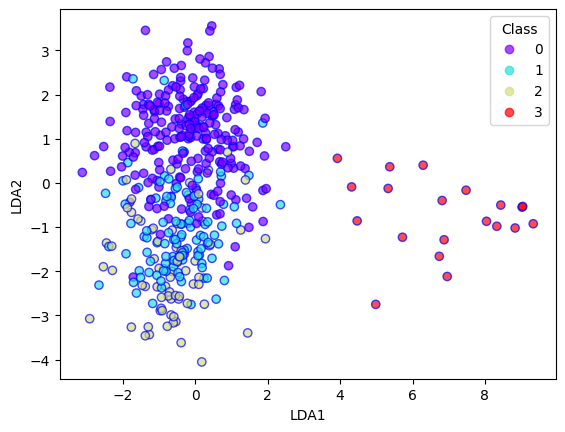

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
X_lda = lda_model.fit_transform(individual_data['mirna'], individual_target['mirna'])

plt.xlabel('LDA1')
plt.ylabel('LDA2')
scatter = plt.scatter(
X_lda[:,0],
X_lda[:,1],
   c=individual_target['mirna'],
cmap='rainbow',
   alpha=0.7,
edgecolors='b'
)
# Adding a legend with class labels
legend_labels = list(set(individual_target['mirna']))  # Assuming individual_target['mirna'] contains class labels
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Class')


In [105]:
new_target={}

for modality in datasets:
    def group(i):
        if i == 3:
            return 1
        else:
            return 0

    applyall = np.vectorize(group)
    new_target[modality] = applyall(individual_target[modality])

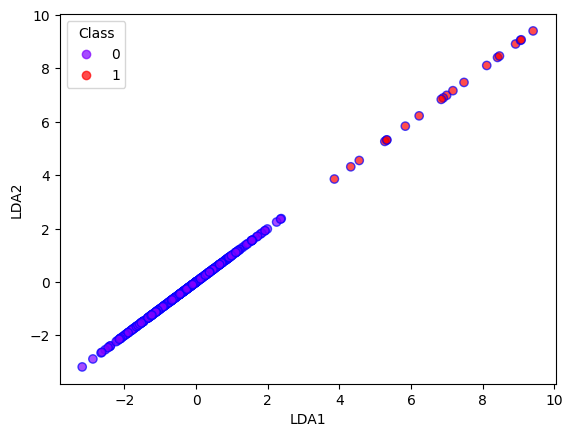

In [106]:

X_lda = lda_model.fit_transform(individual_data['mirna'], new_target['mirna'])
plt.xlabel('LDA1')
plt.ylabel('LDA2')
scatter = plt.scatter(
X_lda,
X_lda,
   c=new_target['mirna'],
cmap='rainbow',
   alpha=0.7,
edgecolors='b'
)
# Adding a legend with class labels
legend_labels = list(set(new_target['mirna']))  # Assuming individual_target['mirna'] contains class labels
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Class')


In [88]:
new_target={}

for modality in datasets:
    def group(i):
        if i==3:
            return 1
        else:
            return 0

    applyall = np.vectorize(group)
    new_target[modality] = applyall(individual_target[modality])

In [113]:
pipelines = {
    'Baseline': LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0),
    'Over Sampler': make_pipeline(RandomOverSampler(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    'SMOTE': make_pipeline(SMOTE(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    'Under Sampler + SMOTE': make_pipeline(RandomUnderSampler(sampling_strategy=0.50), SMOTE(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
}

In [90]:
for name, clf in tqdm(pipelines.items()):
      score, df, train_df = get_cross_metrics(clf, individual_data['mirna'], new_target['mirna'], name, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}, return_train_score=True)
   
      base_metrics_df['mirna'] = pd.concat([base_metrics_df['mirna'], df])
      base_metrics_df_train['mirna'] = pd.concat([base_metrics_df_train['mirna'], train_df])
      base_scores['mirna'].append(score)

100%|██████████| 3/3 [00:21<00:00,  7.32s/it]


In [93]:
Counter(new_target['mirna'])

Counter({0: 428, 1: 20})

In [91]:
base_metrics_df['mirna']

,accuracy,f1,recall (early),recall (late)
Baseline,0.946 +/- 0.009,0.929 +/- 0.005,0.991 +/- 0.009,0.000 +/- 0.000
Random Over Sampler,0.942 +/- 0.013,0.927 +/- 0.007,0.986 +/- 0.014,0.000 +/- 0.000
SMOTE,0.942 +/- 0.013,0.927 +/- 0.007,0.986 +/- 0.014,0.000 +/- 0.000


In [107]:
pipelines = {
    'Under Sampler + SMOTE': make_pipeline(RandomUnderSampler(sampling_strategy=0.25), SMOTE(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    'LDA': make_pipeline(LinearDiscriminantAnalysis(), LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
}

In [111]:
for name, clf in tqdm(pipelines.items()):
      score, df, train_df = get_cross_metrics(clf, individual_data['mirna'], new_target['mirna'], name, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)}, return_train_score=True)
   
      base_metrics_df['mirna'] = pd.concat([base_metrics_df['mirna'], df])
      base_metrics_df_train['mirna'] = pd.concat([base_metrics_df_train['mirna'], train_df])
      base_scores['mirna'].append(score)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


In [112]:
base_metrics_df['mirna']

,accuracy,f1,recall (early),recall (late)
Baseline,0.946 +/- 0.009,0.929 +/- 0.005,0.991 +/- 0.009,0.000 +/- 0.000
Random Over Sampler,0.942 +/- 0.013,0.927 +/- 0.007,0.986 +/- 0.014,0.000 +/- 0.000
SMOTE,0.942 +/- 0.013,0.927 +/- 0.007,0.986 +/- 0.014,0.000 +/- 0.000
Under Sampler + SMOTE,0.875 +/- 0.033,0.894 +/- 0.019,0.911 +/- 0.034,0.100 +/- 0.200
LDA,0.931 +/- 0.013,0.923 +/- 0.006,0.972 +/- 0.016,0.050 +/- 0.100
Under Sampler + SMOTE,0.888 +/- 0.025,0.903 +/- 0.013,0.923 +/- 0.029,0.150 +/- 0.122
LDA,0.931 +/- 0.013,0.923 +/- 0.006,0.972 +/- 0.016,0.050 +/- 0.100


## Merging datasets together

In [65]:
suffixed = {}
target = {}

# Add suffixes to each DataFrame
for key in new_data.keys():
    # Add suffix
    suffixed[key] = new_data[key].add_suffix("_" + key)

# Merge datasets based on index and aligning them with the target

merged = pd.concat(
        [pd.concat(suffixed.values(), axis=1, join="inner"), subtypes], axis=1, join="inner"
)

y = merged['pathologic_stage']

merged_X = (merged.drop(columns='pathologic_stage')).astype("float")

# Encoding the variables
enc = LabelEncoder()
y = enc.fit_transform(y)

def group(i):
    if i==0 or i==1:
        return 0
    else:
        return 1

applyall = np.vectorize(group)
y = applyall(y)

X = {}

for key in data.keys():
    # Extract the corresponding columns for each dataset
    X[key] = (merged.loc[:, suffixed[key].columns]).astype("float")

# Analysis

Let's look at the dataset a bit:

In [320]:
np.array(np.unique(y, return_counts=True)).T

array([[  0, 158],
       [  1,  71],
       [  2,  52],
       [  3,  11]])

In [325]:
for modality in X:
    missing_values = X[modality].isnull().sum()
    print(missing_values[missing_values>0].sort_values(ascending = False))
    # Removing the columns from the prot that have many null values
    missing_values = X['prot'].isnull().sum()
    X['prot'].drop(columns=missing_values[missing_values>0].index, axis=1, inplace=True)
    merged_X.drop(columns=missing_values[missing_values>0].index, axis=1, inplace=True)

Series([], dtype: int64)
Series([], dtype: int64)
PARK7_prot       187
TP53_prot        187
PCNA_prot        187
ATM_prot         187
PXN_prot         187
RAB11A_prot      187
RAB11B_prot      187
SERPINE1_prot    187
SQSTM1_prot      187
CTNNA1_prot      187
ERBB2_prot       187
PRKCA_prot       187
BAP1_prot        187
BECN1_prot       187
TUBA1B_prot      187
RAD51_prot       105
XRCC1_prot       105
WWTR1_prot       105
TYMS_prot        105
RAD50_prot       105
TP53BP1_prot     105
SYP_prot         105
RET_prot         105
SHC1_prot        105
TP63_prot        105
PRDX1_prot       105
STK11_prot       105
RAF1_prot        105
ARID1A_prot      105
PDCD1_prot       105
EPPK1_prot       105
AXL_prot         105
BRCA2_prot       105
CASP9_prot       105
CD274_prot       105
CDKN1A_prot      105
CHGA_prot        105
CTLA4_prot       105
E2F1_prot        105
EZH2_prot        105
NFE2L2_prot      105
GATA6_prot       105
INPP4B_prot      105
KEAP1_prot       105
KRT5_prot        105
LCN2_

## Testing datasets

In [356]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [348]:
merged_mirna = pd.concat([transformed_data['mirna'], subtypes], axis=1, join="inner")

mirna_y = merged_mirna['pathologic_stage']

merged_mirna = (merged_mirna.drop(columns='pathologic_stage')).astype("float")

# Encoding the variables
enc = LabelEncoder()
mirna_y = enc.fit_transform(mirna_y)

In [350]:
mapping: {
    0: 0,
    1: 0,
    2: 1,
    3: 1
}

def group(i):
    if i==0 or i==1:
        return 0
    else:
        return 1

applyall = np.vectorize(group)
mirna_y = applyall(mirna_y)

In [359]:
lr = make_pipeline(RandomUnderSampler(sampling_strategy=0.9, random_state=1), RandomOverSampler(random_state=1), LogisticRegression(solver="lbfgs", n_jobs=-1, max_iter=1000, random_state=0))
scores, test_metrics, train_metrics = get_cross_metrics(lr, merged_mirna, mirna_y, 'Model', scoring={ "f1 (0)": make_scorer(f1_score, pos_label=0), "f1 (1)": make_scorer(f1_score, pos_label=1), "accuracy": "accuracy", 'balanced_accuracy': 'balanced_accuracy'}, return_train_score=True)
display(train_metrics), display(test_metrics)

,f1 (0),f1 (1),accuracy,balanced_accuracy
Model - train,0.842 +/- 0.024,0.660 +/- 0.031,0.785 +/- 0.029,0.864 +/- 0.018


,f1 (0),f1 (1),accuracy,balanced_accuracy
Model,0.730 +/- 0.044,0.356 +/- 0.092,0.620 +/- 0.057,0.578 +/- 0.076


(None, None)

In [330]:
lr = LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

preds = cross_val_predict(lr, X['mirna'], y, n_jobs=-1, cv=skf)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [331]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_pred=preds, y_true=y))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.59      0.64      0.49      0.62      0.56      0.31       158
          1       0.25      0.27      0.75      0.26      0.45      0.19        71
          2       0.23      0.19      0.86      0.21      0.41      0.15        52
          3       0.00      0.00      0.99      0.00      0.00      0.00        11

avg / total       0.42      0.45      0.63      0.43      0.48      0.24       292



https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7341118/
- Here they use SVM to distinguish between stages I/II and III/IV
- We will use this as a basis for our analysis

In [332]:
mapping: {
    0: 0,
    1: 0,
    2: 1,
    3: 1
}

def group(i):
    if i==0 or i==1:
        return 0
    else:
        return 1

applyall = np.vectorize(group)
y_new = applyall(y)
print(y_new)

[1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0]


In [394]:
scaler = StandardScaler()
scaler.fit(X['mirna'])
scaled = scaler.transform(X['mirna'])

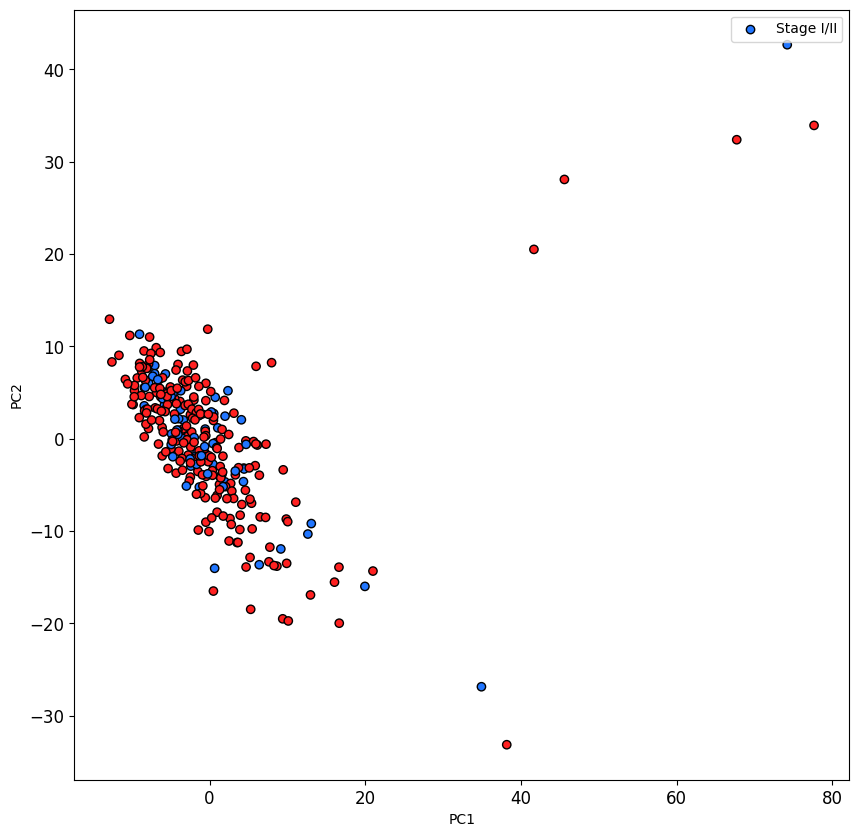

In [404]:
from sklearn.decomposition import PCA
# Assuming 'X' contains your feature data and 'y' contains the class labels

pca = PCA()
X_pca = pca.fit_transform(scaled)
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

plt.figure(figsize=(10,10))
colour = ['#ff2121' if y == 0 else '#2176ff' for y in y_new]

plot = plt.scatter(pc1, pc2, c=colour,edgecolors='#000000')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(labels=['Stage I/II', 'Stage III/IV'])
plt.show()

Text(0, 0.5, 'Proportion of Variance Explained')

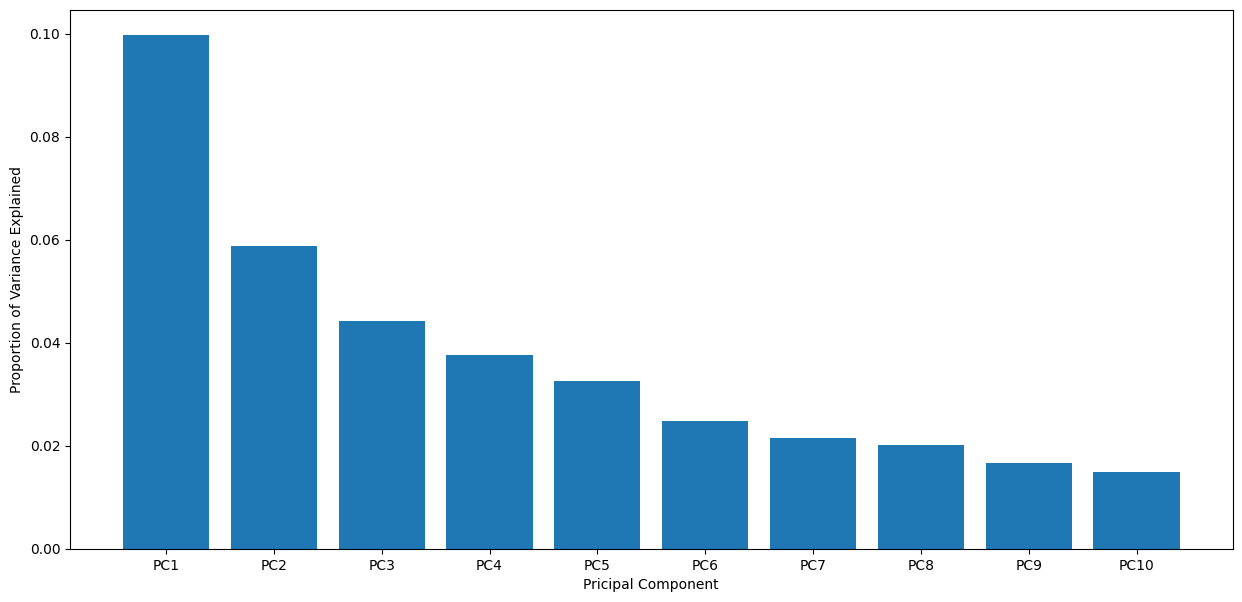

In [390]:
var = pca.explained_variance_ratio_[0:10] #percentage of variance explained
labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
	
plt.figure(figsize=(15,7))
plt.bar(labels,var,)
plt.xlabel('Pricipal Component')
plt.ylabel('Proportion of Variance Explained')

Text(0, 0.5, 'Proportion of Variance Explained')

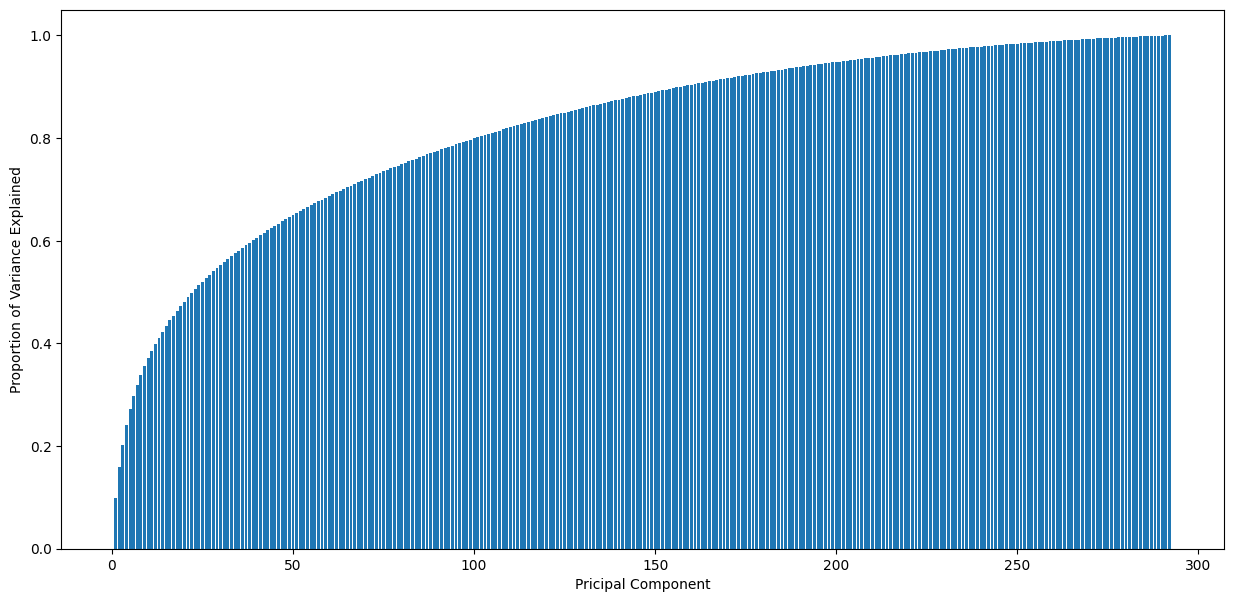

In [409]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(15,7))
plt.bar(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul,)
plt.xlabel('Pricipal Component')
plt.ylabel('Proportion of Variance Explained')

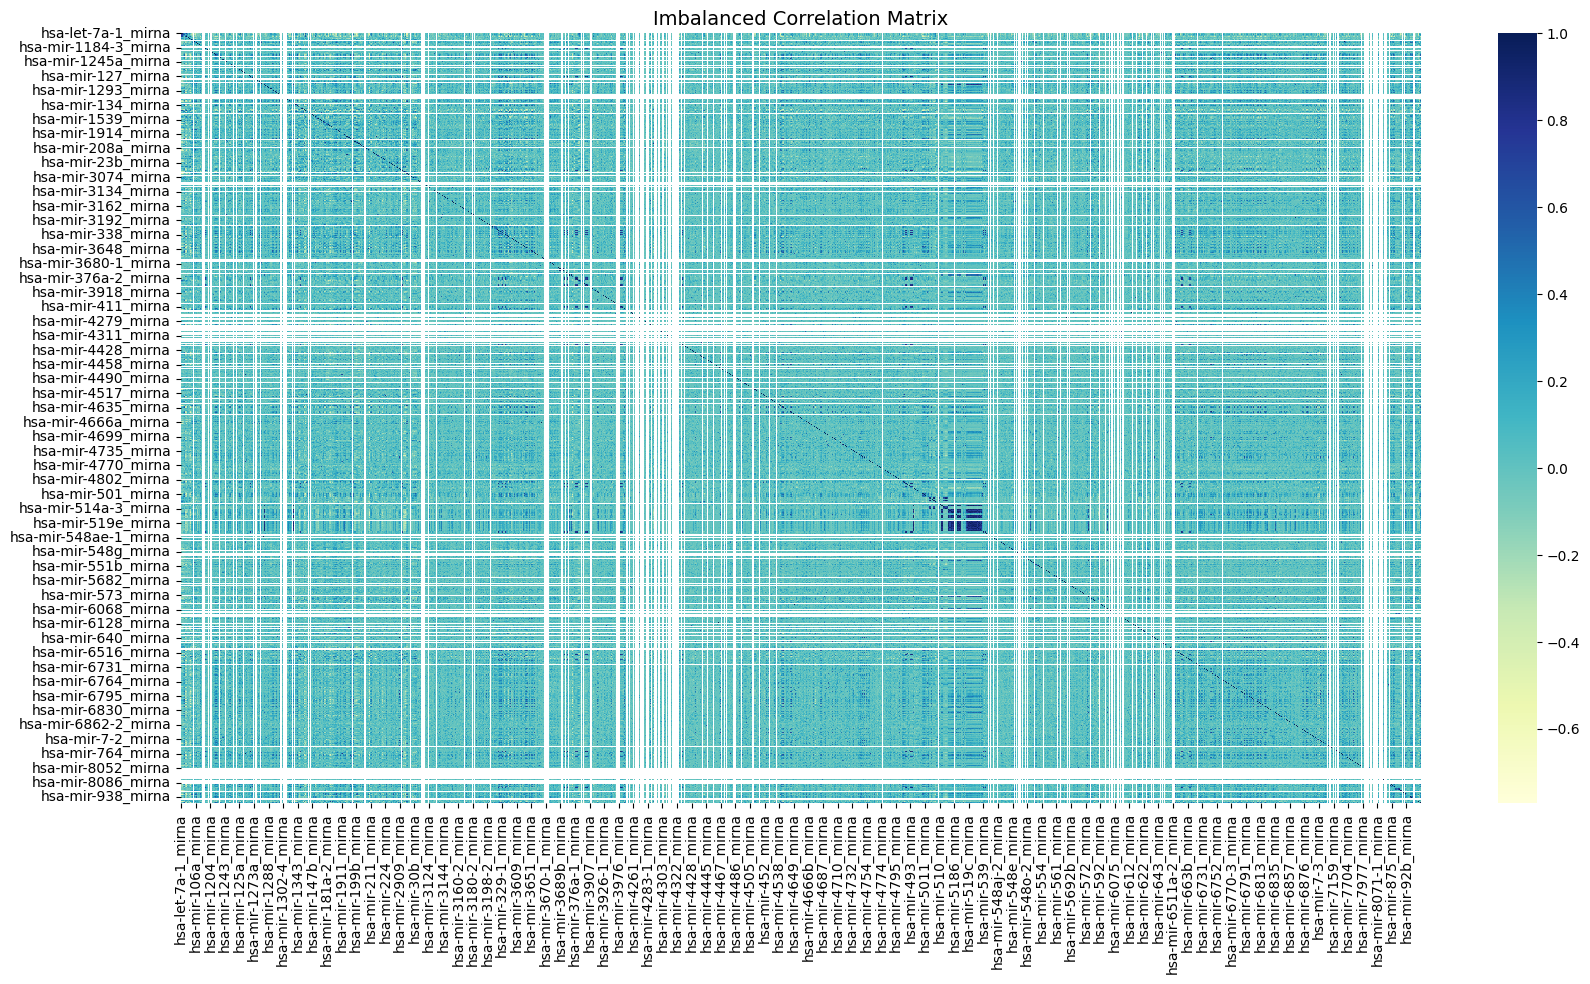

In [181]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr = X['mirna'].corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

In [146]:
lr = LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

preds = cross_val_predict(lr, X['mirna'], y_new, n_jobs=-1, cv=skf)

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_pred=preds, y_true=y_new))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.90      0.22      0.85      0.45      0.21       229
          1       0.38      0.22      0.90      0.28      0.45      0.19        63

avg / total       0.72      0.75      0.37      0.73      0.45      0.21       292



In [333]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
lr = make_pipeline(RandomOverSampler(), LogisticRegression(solver="lbfgs", n_jobs=-1, C=0.01, multi_class='multinomial', max_iter=1000, random_state=0))
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

preds = cross_val_predict(lr, X['mirna'], y_new, n_jobs=-1, cv=skf)

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_pred=preds, y_true=y_new))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.81      0.33      0.81      0.52      0.28       229
          1       0.33      0.33      0.81      0.33      0.52      0.26        63

avg / total       0.71      0.71      0.44      0.71      0.52      0.28       292



In [335]:
from imblearn.ensemble import BalancedRandomForestClassifier
lr = make_pipeline(Debugger(), RandomOverSampler(random_state=1), Debugger(), LogisticRegression(solver="lbfgs", n_jobs=-1, max_iter=1000, random_state=0))
scores, test_metrics, train_metrics = get_cross_metrics(lr, X['mirna'], y_new, 'Model', scoring={ "f1 (0)": make_scorer(f1_score, pos_label=0), "f1 (1)": make_scorer(f1_score, pos_label=1), "accuracy": "accuracy", 'balanced_accuracy': 'balanced_accuracy'}, return_train_score=True)
display(train_metrics), display(test_metrics)

#rf = make_pipeline(BalancedRandomForestClassifier(random_state=0, n_jobs=-1))

Shape of Pre-processed Data: (234, 1116)
Shape of Pre-processed Data: (234, 1116)
Shape of Pre-processed Data: (233, 1116)
Shape of Pre-processed Data: (233, 1116)
              hsa-let-7a-1_mirna  ...  hsa-mir-99b_mirna
TCGA-05-4405           12.942424  ...          14.199968
TCGA-05-4410           12.714788  ...          13.861250
TCGA-05-4417           12.150570  ...          14.081533
TCGA-05-5429           13.544523  ...          14.253674
TCGA-05-5715           13.062130  ...          15.028286

[5 rows x 1116 columns]              hsa-let-7a-1_mirna  ...  hsa-mir-99b_mirna
TCGA-05-4384           13.876267  ...          14.798189
TCGA-05-4396           14.019132  ...          13.997797
TCGA-05-4405           12.942424  ...          14.199968
TCGA-05-4410           12.714788  ...          13.861250
TCGA-05-4417           12.150570  ...          14.081533

[5 rows x 1116 columns]

              hsa-let-7a-1_mirna  ...  hsa-mir-99b_mirna
TCGA-05-4384           13.876267  ...        

,f1 (0),f1 (1),accuracy,balanced_accuracy
Model - train,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


,f1 (0),f1 (1),accuracy,balanced_accuracy
Model,0.819 +/- 0.031,0.288 +/- 0.085,0.713 +/- 0.044,0.551 +/- 0.050


(None, None)

In [192]:
print(scores)

{'fit_time': array([0.2591238 , 0.18554425, 0.27042222, 0.179533  , 0.1744988 ]), 'score_time': array([0.11819124, 0.07047081, 0.0976088 , 0.05484104, 0.06926727]), 'test_f1 (0)': array([0.8125    , 0.77894737, 0.76744186, 0.66666667, 0.83516484]), 'train_f1 (0)': array([0.84455959, 0.84816754, 0.8034188 , 0.79525223, 0.79083095]), 'test_f1 (1)': array([0.18181818, 0.08695652, 0.33333333, 0.22857143, 0.4       ]), 'train_f1 (1)': array([0.25      , 0.30952381, 0.41025641, 0.47328244, 0.38655462]), 'test_accuracy': array([0.69491525, 0.6440678 , 0.65517241, 0.53448276, 0.74137931]), 'train_accuracy': array([0.74248927, 0.75107296, 0.70512821, 0.70512821, 0.68803419]), 'test_balanced_accuracy': array([0.50083612, 0.44063545, 0.55897436, 0.46014493, 0.62137681]), 'train_balanced_accuracy': array([0.54535519, 0.57262295, 0.62315217, 0.67004179, 0.60253938])}


# Base Metrics

In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

estimators = [
    ("logistic", LogisticRegression(solver="lbfgs", n_jobs=-1, multi_class='multinomial', max_iter=1000, random_state=0)),
    ("lasso", LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000, random_state=0)),
    ("elasticnet", SGDClassifier(loss="log_loss", penalty="elasticnet", n_jobs=-1, random_state=0)),
    ("random_forest", RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=0))),
    ("svc", CalibratedClassifierCV(LinearSVC(dual=True, C=10, random_state=0), cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True), n_jobs=-1)),
]

In [410]:
class Debugger(BaseEstimator, TransformerMixin):
    def transform(self, data):
        # Here you just print what you need + return the actual data. You're not transforming anything.

        print("Shape of Pre-processed Data:", data.shape)
        #print(pd.DataFrame(data).head())
        return data

    def fit(self, data, y=None, **fit_params):
        # No need to fit anything, because this is not an actual  transformation.

        return self


In [69]:
from imblearn.pipeline import make_pipeline

base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
   base_metrics_df[modality] = pd.DataFrame()
   base_metrics_df_train[modality] = pd.DataFrame()
   base_scores[modality] = []
   
   for name, clf in tqdm(estimators):
      score, df = get_cross_metrics(clf, X[modality], y, name, scoring={"accuracy": "accuracy", "balanced_accuracy":'balanced_accuracy', "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)})
   
      base_metrics_df[modality] = pd.concat([base_metrics_df[modality], df])
      base_metrics_df_train[modality] = pd.concat([base_metrics_df_train[modality], train_df])
      base_scores[modality].append(score)

 83%|████████▎ | 5/6 [00:10<00:01,  1.74s/it]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

In [70]:
display(base_metrics_df['mirna']), display(base_metrics_df['mrna']), display(base_metrics_df['prot']), display(base_metrics_df['lncrna'])

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.754 +/- 0.035,0.560 +/- 0.046,0.727 +/- 0.033,0.900 +/- 0.035,0.221 +/- 0.086
lasso,0.726 +/- 0.044,0.560 +/- 0.060,0.715 +/- 0.043,0.852 +/- 0.037,0.269 +/- 0.102
elasticnet,0.579 +/- 0.213,0.511 +/- 0.026,0.532 +/- 0.195,0.622 +/- 0.380,0.400 +/- 0.405
random_forest,0.777 +/- 0.014,0.496 +/- 0.005,0.686 +/- 0.013,0.991 +/- 0.011,0.000 +/- 0.000
deep_nn,0.764 +/- 0.006,0.534 +/- 0.023,0.715 +/- 0.020,0.939 +/- 0.025,0.129 +/- 0.070
svc,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.753 +/- 0.042,0.515 +/- 0.041,0.701 +/- 0.040,0.934 +/- 0.046,0.096 +/- 0.060
lasso,0.726 +/- 0.029,0.492 +/- 0.033,0.679 +/- 0.028,0.904 +/- 0.038,0.079 +/- 0.072
elasticnet,0.706 +/- 0.091,0.504 +/- 0.015,0.668 +/- 0.043,0.855 +/- 0.154,0.154 +/- 0.161
random_forest,0.771 +/- 0.016,0.491 +/- 0.008,0.683 +/- 0.013,0.983 +/- 0.016,0.000 +/- 0.000
deep_nn,0.713 +/- 0.063,0.530 +/- 0.070,0.695 +/- 0.060,0.851 +/- 0.068,0.209 +/- 0.121
svc,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.723 +/- 0.045,0.540 +/- 0.073,0.705 +/- 0.048,0.860 +/- 0.035,0.221 +/- 0.130
lasso,0.736 +/- 0.040,0.525 +/- 0.067,0.704 +/- 0.043,0.895 +/- 0.032,0.155 +/- 0.108
elasticnet,0.661 +/- 0.046,0.538 +/- 0.050,0.671 +/- 0.037,0.756 +/- 0.059,0.319 +/- 0.095
random_forest,0.774 +/- 0.016,0.499 +/- 0.021,0.690 +/- 0.018,0.983 +/- 0.016,0.015 +/- 0.031
deep_nn,0.723 +/- 0.031,0.524 +/- 0.067,0.694 +/- 0.043,0.873 +/- 0.037,0.174 +/- 0.146
svc,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000


,accuracy,balanced_accuracy,f1,recall (early),recall (late)
logistic,0.764 +/- 0.021,0.498 +/- 0.020,0.689 +/- 0.021,0.965 +/- 0.026,0.032 +/- 0.039
lasso,0.757 +/- 0.020,0.512 +/- 0.036,0.695 +/- 0.027,0.943 +/- 0.041,0.081 +/- 0.103
elasticnet,0.740 +/- 0.043,0.496 +/- 0.051,0.682 +/- 0.037,0.926 +/- 0.061,0.065 +/- 0.097
random_forest,0.771 +/- 0.018,0.491 +/- 0.013,0.683 +/- 0.010,0.983 +/- 0.025,0.000 +/- 0.000
deep_nn,0.723 +/- 0.030,0.507 +/- 0.023,0.689 +/- 0.020,0.887 +/- 0.042,0.127 +/- 0.039
svc,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000


(None, None, None, None)

In [71]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        # calculating scores
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)

        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)


In [77]:
estimator_mapping = {
    'mirna': ['logistic', 'lasso', 'elasticnet', 'deep_nn'],
    'mrna': ['logistic', 'lasso', 'elasticnet', 'deep_nn'],
    'prot': ['logistic', 'lasso', 'elasticnet', 'deep_nn'],
    'lncrna': ['logistic', 'lasso', 'elasticnet', 'deep_nn']
}

classifiers = {}

for modality in datasets:
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in estimator_mapping[modality] if x == name)]
    classifiers[modality] = ModalityPipeline(estimator_list, cv=3)

In [78]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":'balanced_accuracy', "f1": make_scorer(f1_score, average='weighted'), 'recall (early)': make_scorer(recall_multiclass, label=0), 'recall (late)': make_scorer(recall_multiclass, label=1)})
    modality_metrics = pd.concat([modality_metrics, df])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [04:30<00:00, 67.63s/it] 


In [79]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (early),recall (late)
mirna,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000
mrna,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000
prot,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000
lncrna,0.784 +/- 0.007,0.500 +/- 0.000,0.689 +/- 0.010,1.000 +/- 0.000,0.000 +/- 0.000


In [ ]:
from imblearn.pipeline import make_pipeline

base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
   base_metrics_df[modality] = pd.DataFrame()
   base_metrics_df_train[modality] = pd.DataFrame()
   base_scores[modality] = []
   
   for name, clf in tqdm(estimators):
      score, df, train_df = get_cross_metrics(clf, X[modality], y_new, name, scoring={ "f1 (I/II)": make_scorer(f1_score, pos_label=0), "f1 (III/IV)": make_scorer(f1_score, pos_label=1), "accuracy": "accuracy", 'balanced_accuracy': 'balanced_accuracy'}, return_train_score=True)
   
      base_metrics_df[modality] = pd.concat([base_metrics_df[modality], df])
      base_metrics_df_train[modality] = pd.concat([base_metrics_df_train[modality], train_df])
      base_scores[modality].append(score)

In [419]:
display(base_metrics_df['mirna']), display(base_metrics_df['mrna']), display(base_metrics_df['prot']), display(base_metrics_df['lncrna'])

,f1 (I/II),f1 (III/IV),accuracy,balanced_accuracy
logistic,0.752 +/- 0.037,0.319 +/- 0.086,0.637 +/- 0.048,0.548 +/- 0.061
lasso,0.734 +/- 0.025,0.331 +/- 0.077,0.620 +/- 0.034,0.555 +/- 0.059
deep_nn,0.814 +/- 0.048,0.388 +/- 0.167,0.716 +/- 0.073,0.612 +/- 0.116


,f1 (I/II),f1 (III/IV),accuracy,balanced_accuracy
logistic,0.752 +/- 0.069,0.300 +/- 0.057,0.637 +/- 0.081,0.532 +/- 0.060
lasso,0.691 +/- 0.053,0.260 +/- 0.060,0.568 +/- 0.048,0.494 +/- 0.031
deep_nn,0.705 +/- 0.063,0.299 +/- 0.069,0.589 +/- 0.063,0.525 +/- 0.059


,f1 (I/II),f1 (III/IV),accuracy,balanced_accuracy
logistic,0.694 +/- 0.034,0.315 +/- 0.071,0.579 +/- 0.033,0.536 +/- 0.053
lasso,0.675 +/- 0.034,0.338 +/- 0.088,0.565 +/- 0.045,0.549 +/- 0.078
deep_nn,0.723 +/- 0.025,0.314 +/- 0.100,0.606 +/- 0.040,0.542 +/- 0.080


,f1 (I/II),f1 (III/IV),accuracy,balanced_accuracy
logistic,0.787 +/- 0.046,0.299 +/- 0.053,0.674 +/- 0.058,0.546 +/- 0.044
lasso,0.700 +/- 0.044,0.191 +/- 0.132,0.565 +/- 0.058,0.451 +/- 0.100
deep_nn,0.735 +/- 0.068,0.249 +/- 0.060,0.613 +/- 0.076,0.500 +/- 0.048


(None, None, None, None)

In [415]:
display(base_metrics_df['mirna']), display(base_metrics_df['mrna']), display(base_metrics_df['prot']), display(base_metrics_df['lncrna'])

,f1,accuracy
logistic,0.730 +/- 0.031,0.757 +/- 0.031
lasso,0.715 +/- 0.043,0.726 +/- 0.044
elasticnet,0.650 +/- 0.107,0.689 +/- 0.136
random_forest,0.688 +/- 0.012,0.781 +/- 0.011
deep_nn,0.703 +/- 0.034,0.747 +/- 0.021
svc,0.689 +/- 0.010,0.784 +/- 0.007


,f1,accuracy
logistic,0.701 +/- 0.040,0.753 +/- 0.042
lasso,0.679 +/- 0.026,0.726 +/- 0.031
elasticnet,0.687 +/- 0.024,0.750 +/- 0.036
random_forest,0.684 +/- 0.015,0.774 +/- 0.018
deep_nn,0.698 +/- 0.045,0.716 +/- 0.032
svc,0.689 +/- 0.010,0.784 +/- 0.007


,f1,accuracy
logistic,0.705 +/- 0.048,0.723 +/- 0.045
lasso,0.704 +/- 0.043,0.736 +/- 0.040
elasticnet,0.671 +/- 0.037,0.661 +/- 0.046
random_forest,0.690 +/- 0.018,0.774 +/- 0.016
deep_nn,0.694 +/- 0.043,0.723 +/- 0.031
svc,0.689 +/- 0.010,0.784 +/- 0.007


,f1,accuracy
logistic,0.689 +/- 0.028,0.757 +/- 0.020
lasso,0.667 +/- 0.025,0.702 +/- 0.024
elasticnet,0.682 +/- 0.039,0.712 +/- 0.046
random_forest,0.683 +/- 0.006,0.771 +/- 0.008
deep_nn,0.662 +/- 0.033,0.709 +/- 0.040
svc,0.689 +/- 0.010,0.784 +/- 0.007


(None, None, None, None)

In [ ]:
estimator_names = [
    "logistic",
    "lasso",
    "elasticnet",
    "random_forest",
    "deep_nn",
    "svc"
]

In [ ]:
def plot_scores(estimator_names, scorers, metrics=["f1", "accuracy"]):
    score_lists = {}
    for metric in metrics:
        score_lists[metric] = [score["test_" + metric] for score in scorers]

    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        sns.boxplot(data=_list, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}).set_xticklabels(estimator_names, rotation=45)
        plt.title(title)

In [ ]:
plot_scores(estimator_names, base_scores['cnv'])

In [ ]:
plot_scores(estimator_names, base_scores['mrna'])

In [ ]:
plot_scores(estimator_names, base_scores['prot'])